# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [4]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import re

from tqdm.auto import tqdm

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8')

In [9]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [11]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [12]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [13]:
df_reviews.sample(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
38587,tt0165581,tvSeries,The King of Queens,The King of Queens,1998,2007,22,0,Comedy,7.3,73505,"Here in Germany ""King of Queens"" has a big big...",10,pos,1,test,2698
31522,tt0434345,movie,Snow White,Snow White,2005,\N,111,0,Drama,5.8,521,"Snow White, which just came out in Locarno, wh...",4,neg,0,train,7679
4398,tt0364986,movie,Ben & Arthur,Ben & Arthur,2002,\N,85,0,"Drama,Romance,Thriller",2.3,7492,"Oh, Sam Mraovich, we know you tried so hard. T...",2,neg,0,train,9135
7761,tt0144142,movie,Committed,Committed,2000,\N,98,0,"Comedy,Drama",5.1,3584,I saw this film right in the middle while goin...,4,neg,0,test,3085
16057,tt0085657,tvMovie,Heart of Steel,Heart of Steel,1983,\N,100,0,Drama,6.7,99,Emory is a Cincinatti steel worker like his fa...,9,pos,1,train,2045
13382,tt0071950,movie,Footprints on the Moon,Le orme,1975,\N,96,0,"Mystery,Thriller",6.7,1546,A very insightful psychological thriller! Foot...,9,pos,1,test,6425
34923,tt0167059,movie,The Book of Life,The Book of Life,1998,\N,63,0,"Comedy,Fantasy",6.5,1796,This 1-hour 30-minute inside joke is best unde...,8,pos,1,test,5608
11346,tt0085474,tvSpecial,Eddie Murphy: Delirious,Eddie Murphy: Delirious,1983,\N,69,0,Comedy,8.2,15892,EDDIE MURPHY DELIRIOUS is easily the funniest ...,10,pos,1,train,2928
41847,tt0314722,movie,The Stabilizer,The Stabilizer,1986,\N,87,0,Action,6.2,281,Do you like explosions? How about fighting? We...,10,pos,1,test,9437
38206,tt0187993,movie,The Instructor,The Instructor,1981,\N,91,0,"Action,Drama",4.6,63,You might suspect that the plot of this movie ...,1,neg,0,test,6592


In [14]:
df_reviews[df_reviews.isna().any(axis=1)]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


A pesar de que existen datos faltantes en algunas columnas de 2 filas, no influyen puesto que vamos a analizar el comentario de la película, no es necesario tomar acciones respecto a esto.

In [15]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23616
Name: count, dtype: int64

In [16]:
df_reviews['review']

0        The pakage implies that Warren Beatty and Gold...
1        How the hell did they get this made?! Presenti...
2        There is no real story the film seems more lik...
3        Um .... a serious film about troubled teens in...
4        I'm totally agree with GarryJohal from Singapo...
                               ...                        
47326    This is another of my favorite Columbos. It sp...
47327    Talk about being boring! I got this expecting ...
47328    I never thought I'd say this about a biopic, b...
47329    Spirit and Chaos is an artistic biopic of Miya...
47330    I'll make this brief. This was a joy to watch....
Name: review, Length: 47331, dtype: object

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

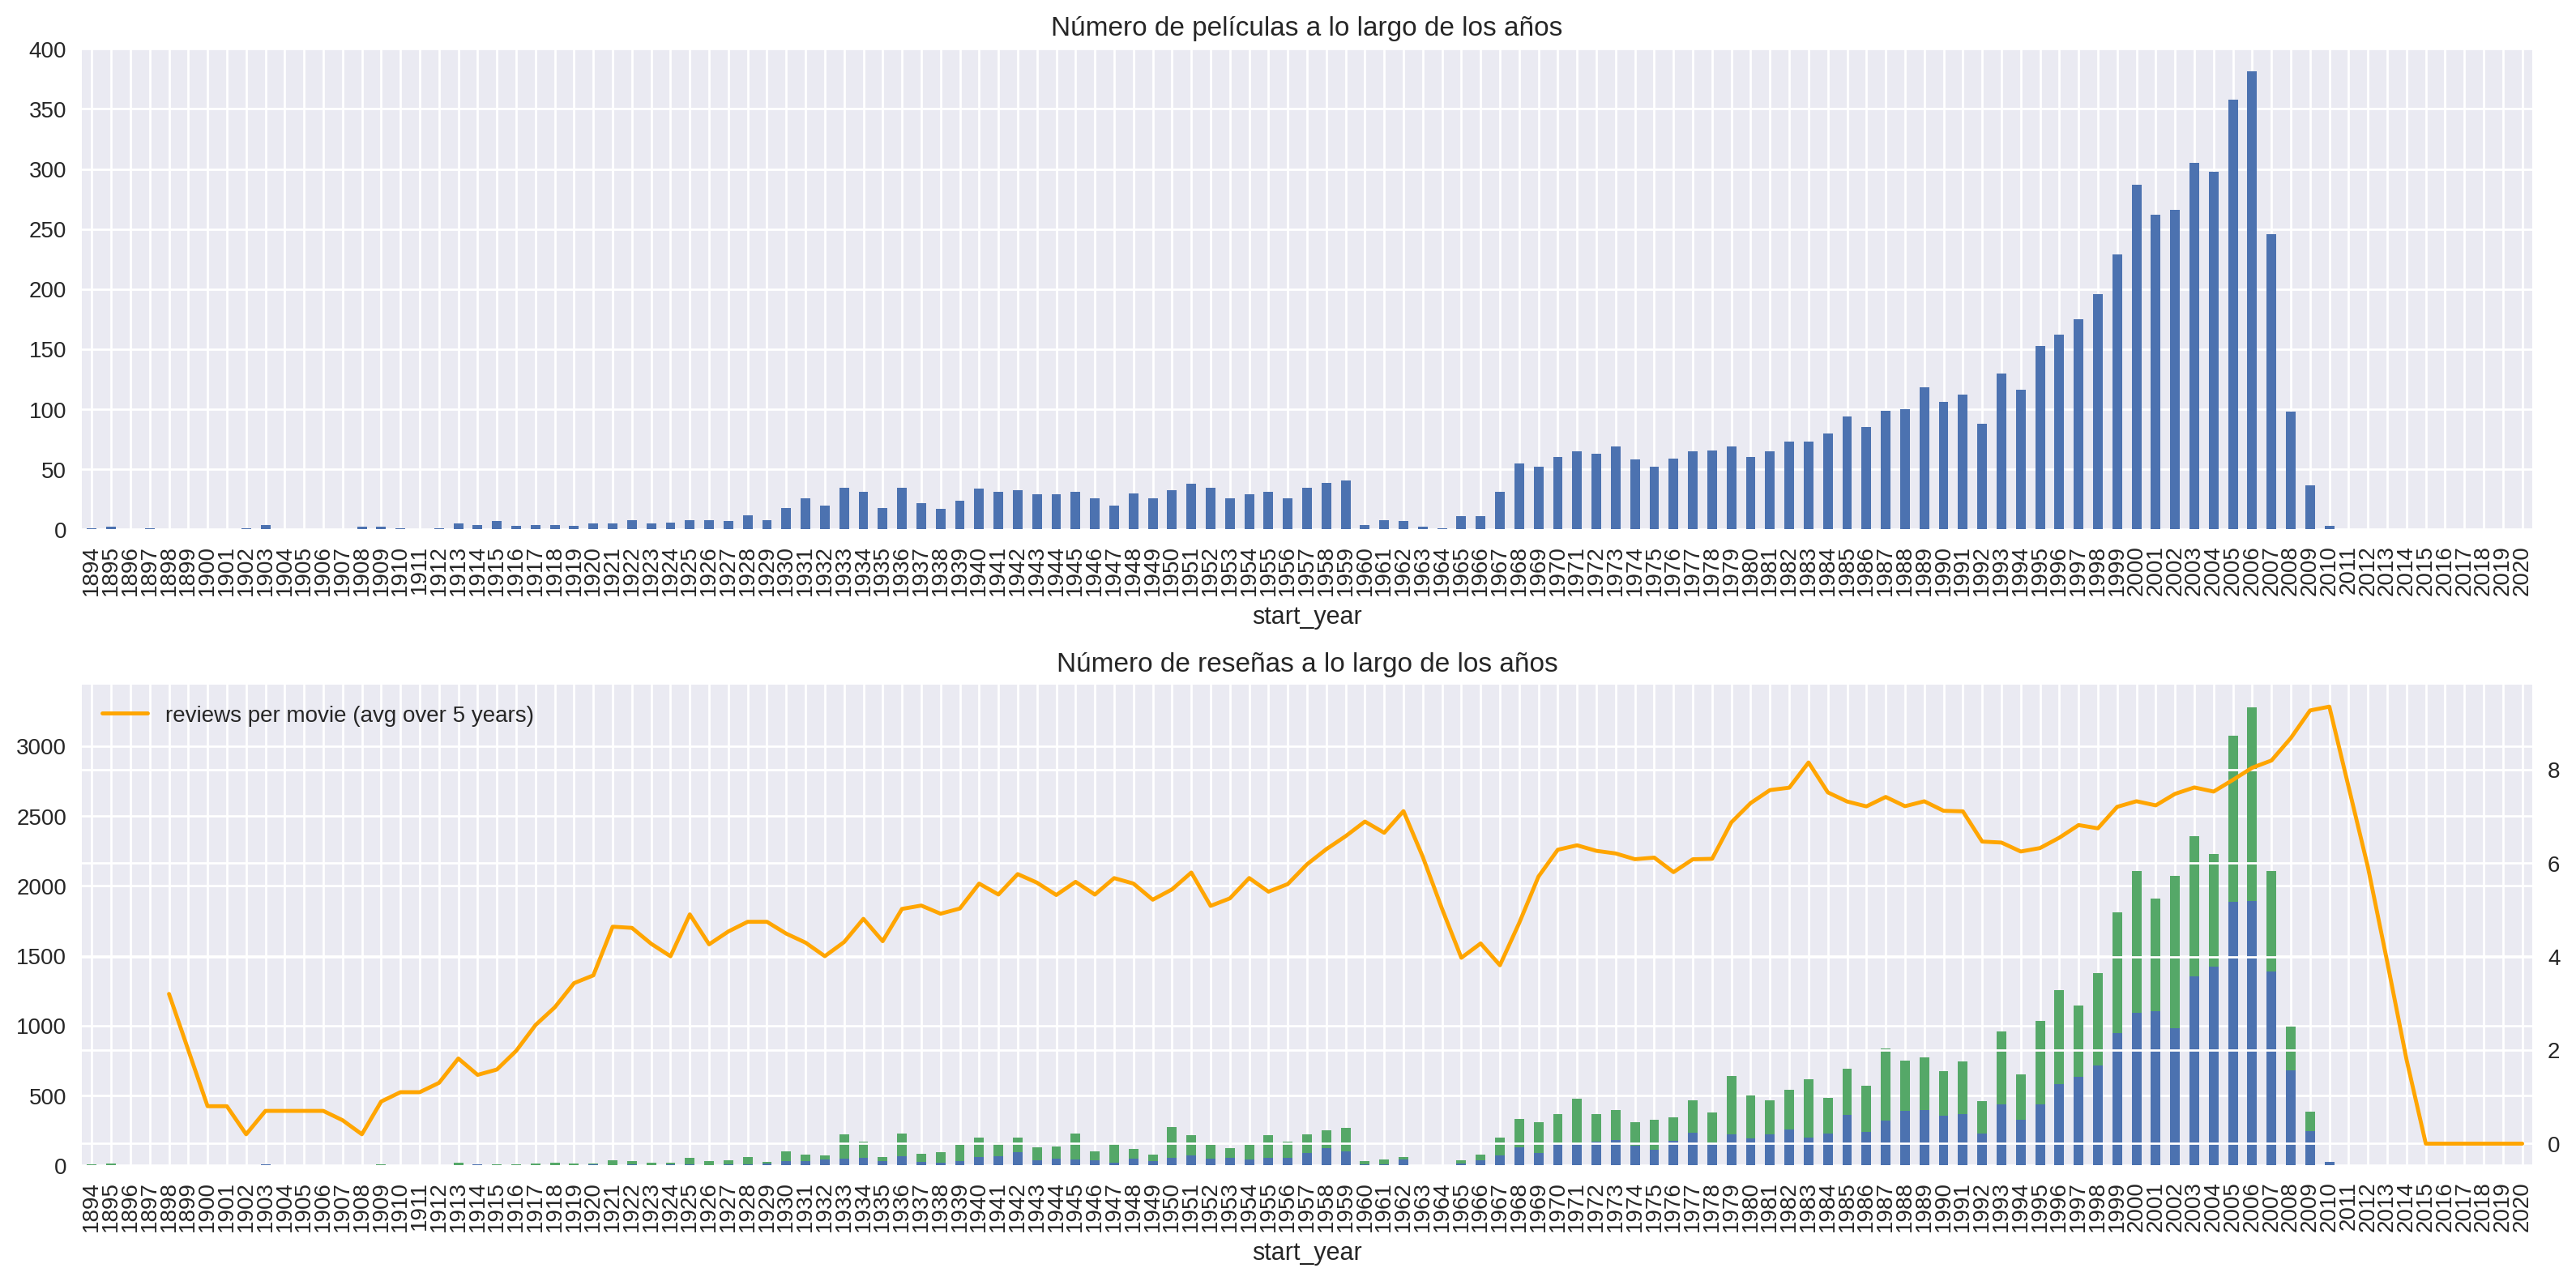

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Se observa que el número de películas y sus respectivas reseñas, tienden a crecer a medida que avanzan los años, salvo por un declive en los últimos años de los que se tienen datos.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

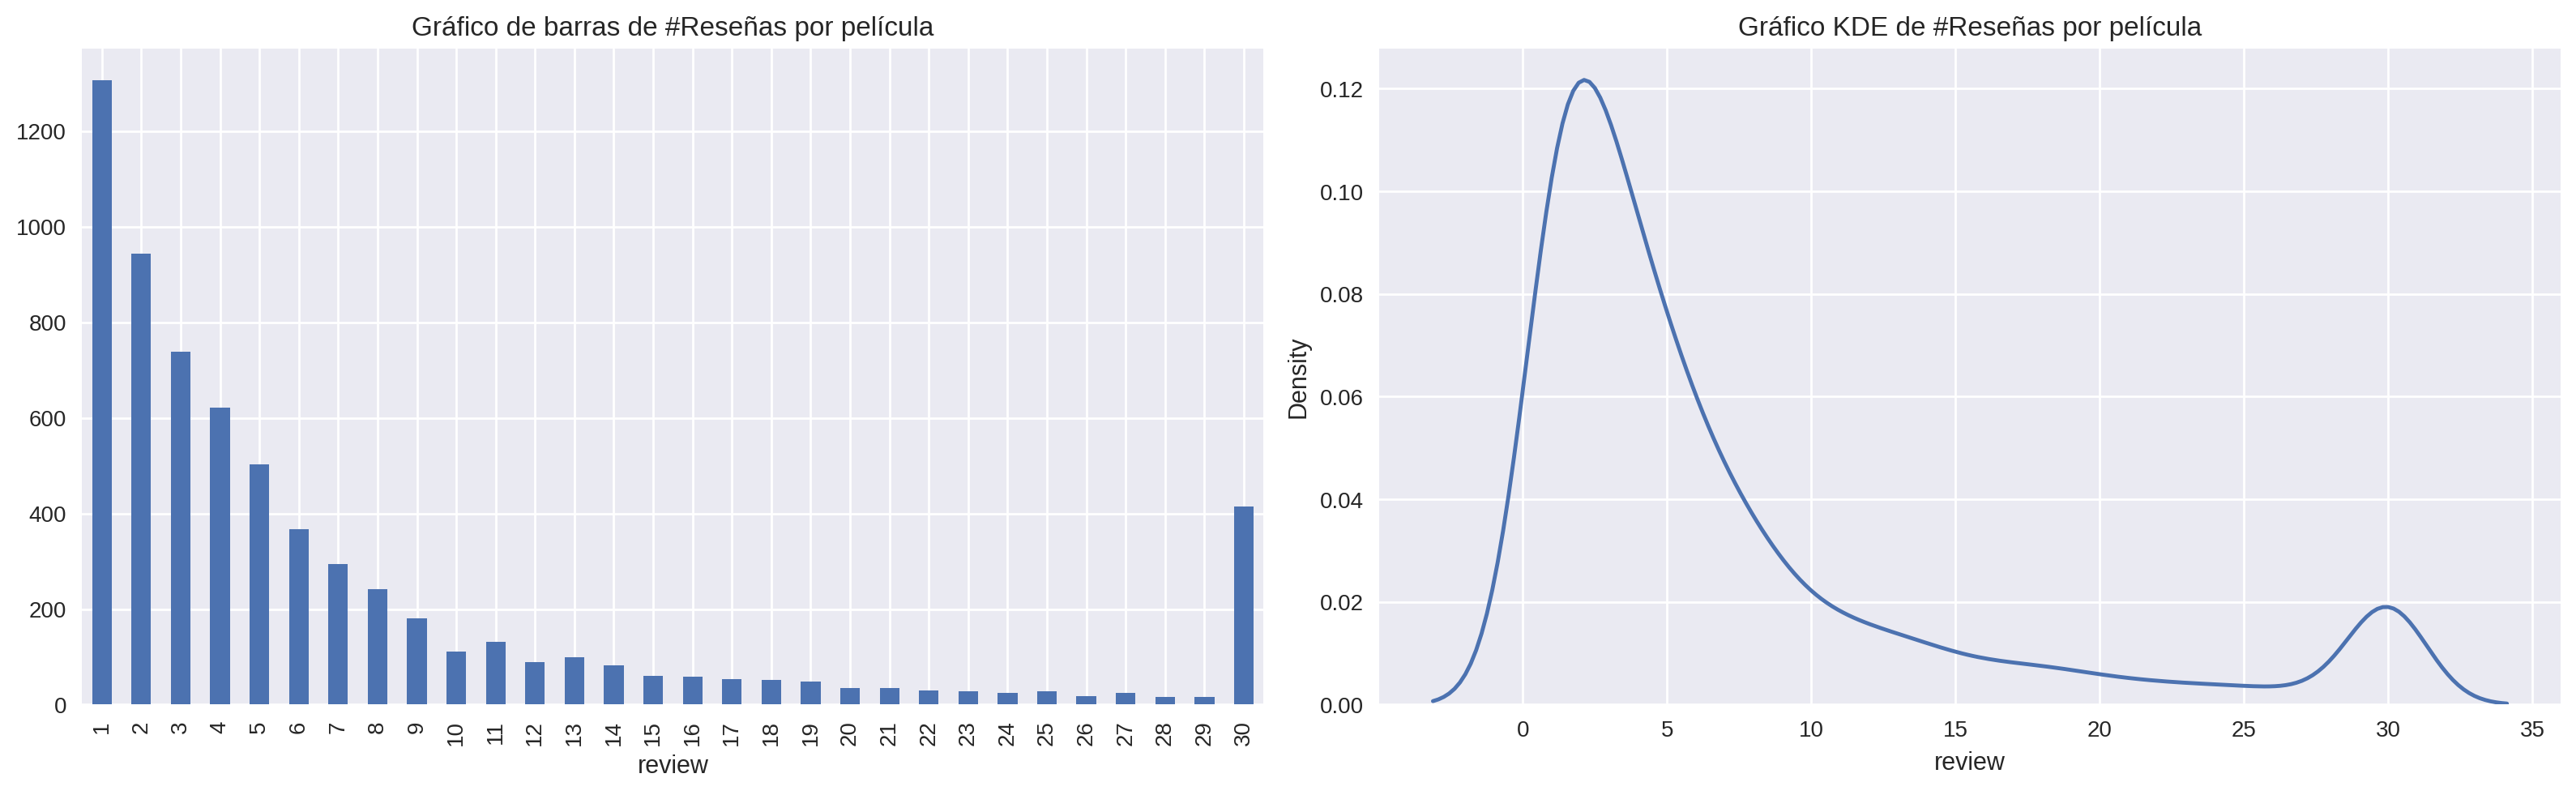

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

Se puede observar que la mayoría de películas tienen pocas reseñas (1-5). El número de películas con mcuhas reseñas va decayendo a medida que aumenta esta última cantidad, salvo por un pico en que varias películas acumulan 30 comentarios.

**Distribución de las puntuaciones**

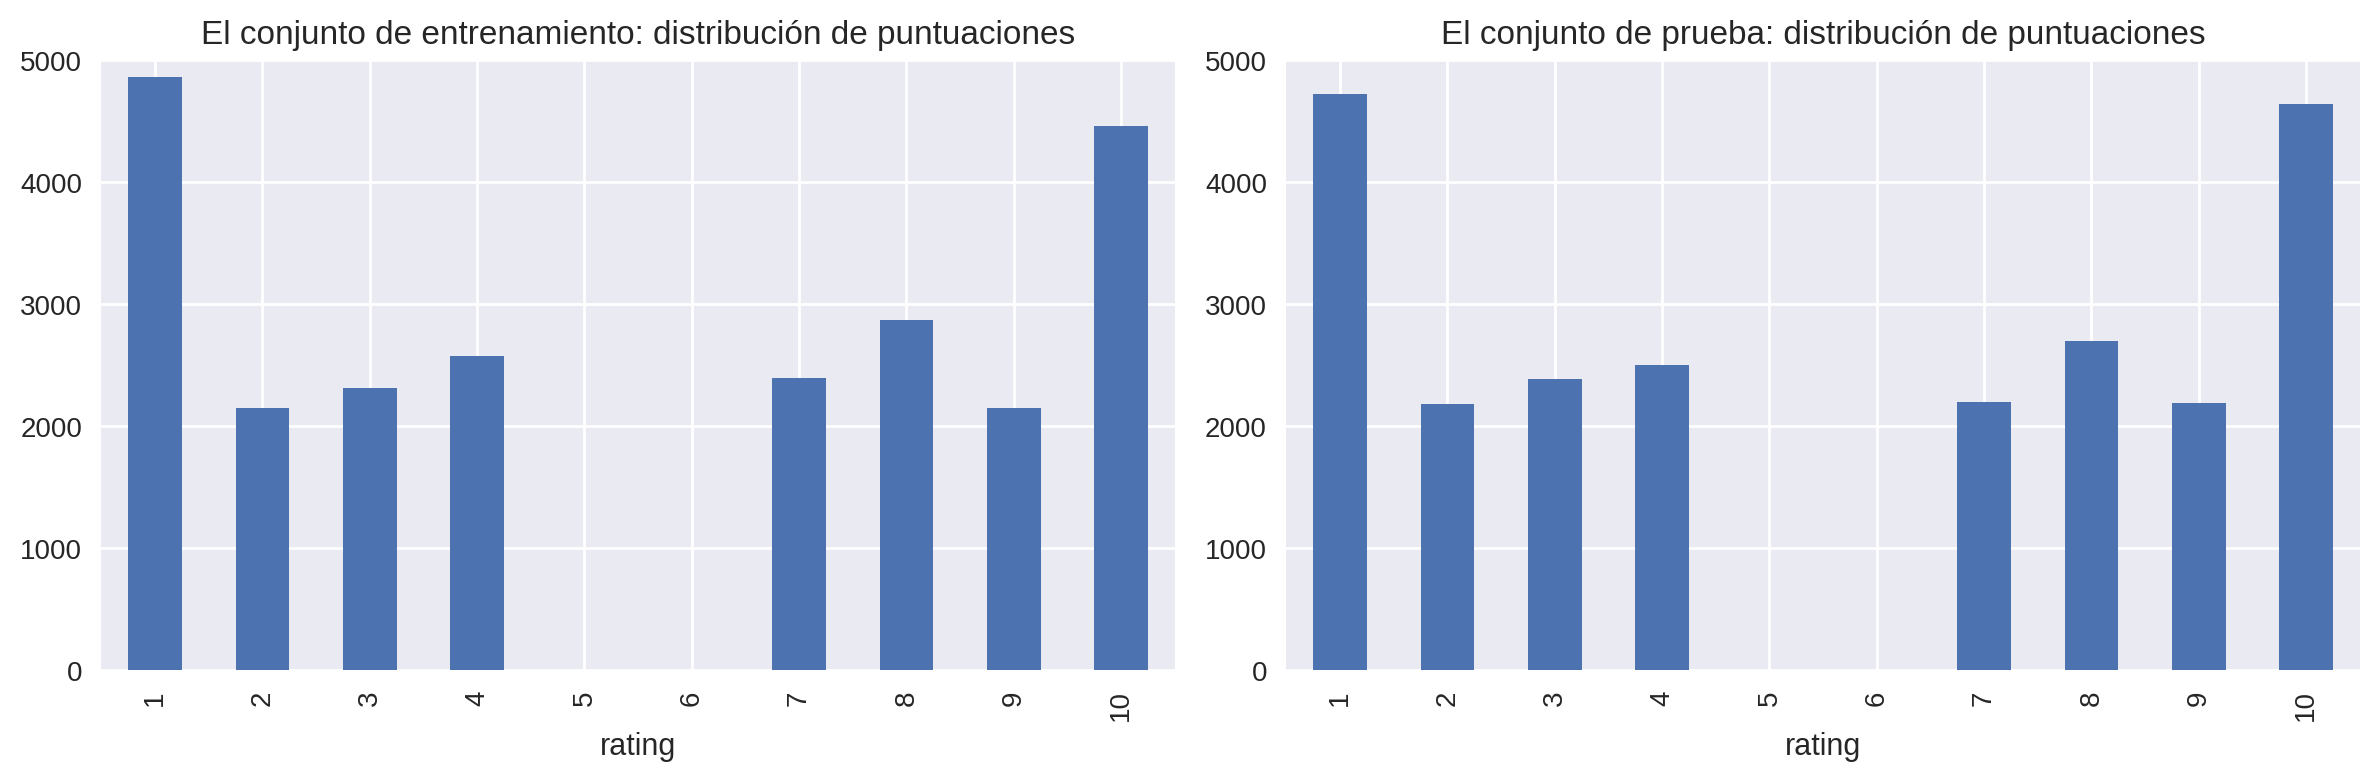

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

- Dado que el conjunto de datos ya tiene una columna para separar el conjunto de entrenamiento, del conjunto de prueba, se analiza la distribución de las puntuaciones que recibió cada película.
- Esto es relevante ya que la puntuación se asocia a si se considera que el comentario es positivo o negativo (positivo entre 7 y 10, negativo entre 1 y 4).
- Se puede observar que las puntuaciones en ambos conjuntos están distribuidos de manera pareja, ya que tienen similar número de películas para cada score.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/tmp/ipykernel_37429/1324160450.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
/tmp/ipykernel_37429/1324160450.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
/tmp/ipykernel_37429/1324160450.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
/tmp/ipykernel_37429/1324160450.py:31: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please updat

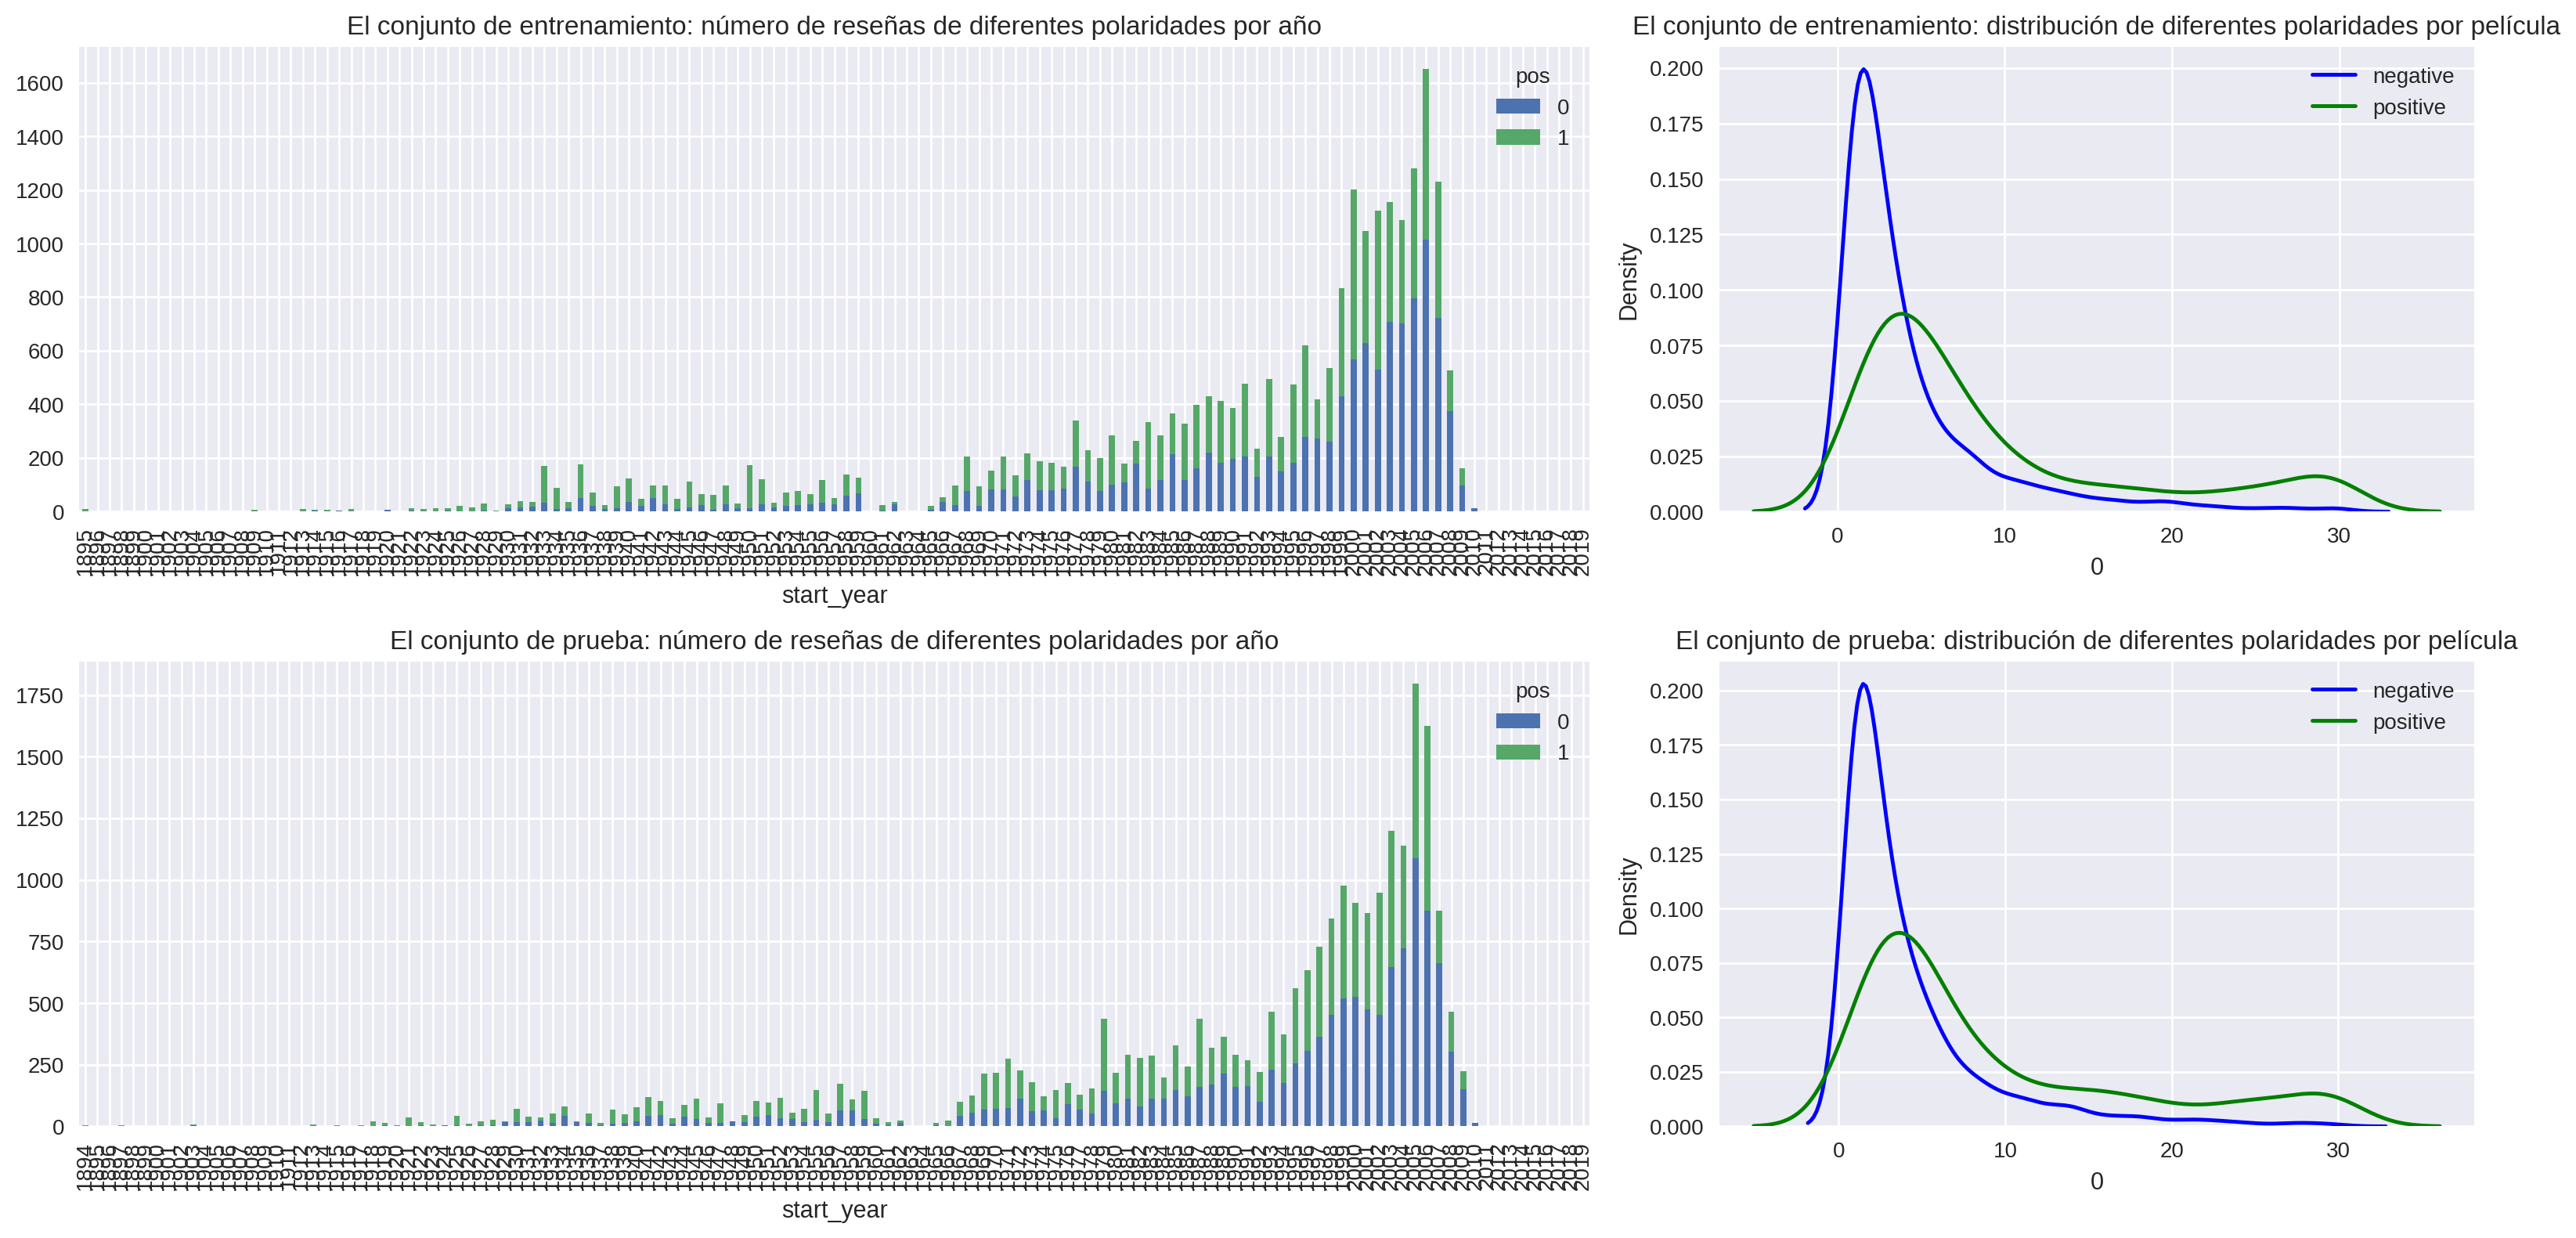

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

- La proporción de reseñas negativas y positivas es relativamente balanceada tanto en el conjunto de entrenamiento como de prueba.
- Según los gráficos kde, muchas películas tienen solo 1-2 reseñas negativas (pico curvas en azul), mientras que  algunas acumulan muchas reseñas positivas (curvas verdes) y por ende están mas distribuidas.
- El conjunto de prueba y el de entrenamiento tienen una distribución similar, lo cual es bueno para el entrenamiento de los modelos.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [21]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [22]:
# Cambio el texto a minúsculas
df_reviews['review_norm'] = df_reviews['review'].str.lower()

In [23]:
#función para eliminar todo lo que no sean letras mayúsculas y minúsculas
def limpieza (text):
    pattern = r"[^a-zA-Z]"
    text_clean = re.sub(pattern," ",text)
    text_clean = " ".join(text_clean.split())
    return text_clean

In [24]:
#aplicación de la función
df_reviews['review_norm'] = df_reviews['review_norm'].apply(limpieza)
df_reviews['review_norm'].loc[4]

'i m totally agree with garryjohal from singapore s comments about this film quotation yes non singaporean s can t see what s the big deal about this film some of the references in this film fly right over the head of foreign viewers and mostly singaporeans are the ones who would actually get it it s still not quite the truth and as a malaysian chinese i do get it although i don t speak hokkien because we do have the similar problems in malaysia too i know that it s really hard to understand and to accept this as a reality but it is definitely not a no real story i was pleased to see this film outside malaysia because it will and definitely be banned in malaysia too which means either you get it in illegal copied vcds or dvds or hope that someone to be kind enough to share it in the internet this is not an another violent teen drama because it portrays the reality which exists in singapore and in malaysia too in an interesting way sad humour i was just a little sad to know that this fi

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [25]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


In [26]:
#comprobación del # de positivos y negativos en el target
train_target.value_counts()

pos
0    11912
1    11884
Name: count, dtype: int64

In [27]:
#comprobación del # de positivos y negativos en el target
test_target.value_counts()

pos
0    11803
1    11732
Name: count, dtype: int64

Se comprueba que los conjuntos de entrenamiento y prueba tienen un número muy similar de casos con reseñas positivas y negativas.

## Trabajar con modelos

### Modelo 0 - Constante

In [28]:
from sklearn.dummy import DummyClassifier

In [29]:
dummy = DummyClassifier()

In [30]:
dummy.fit(df_reviews_train,train_target)
dummy_pred = dummy.predict(df_reviews_test)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


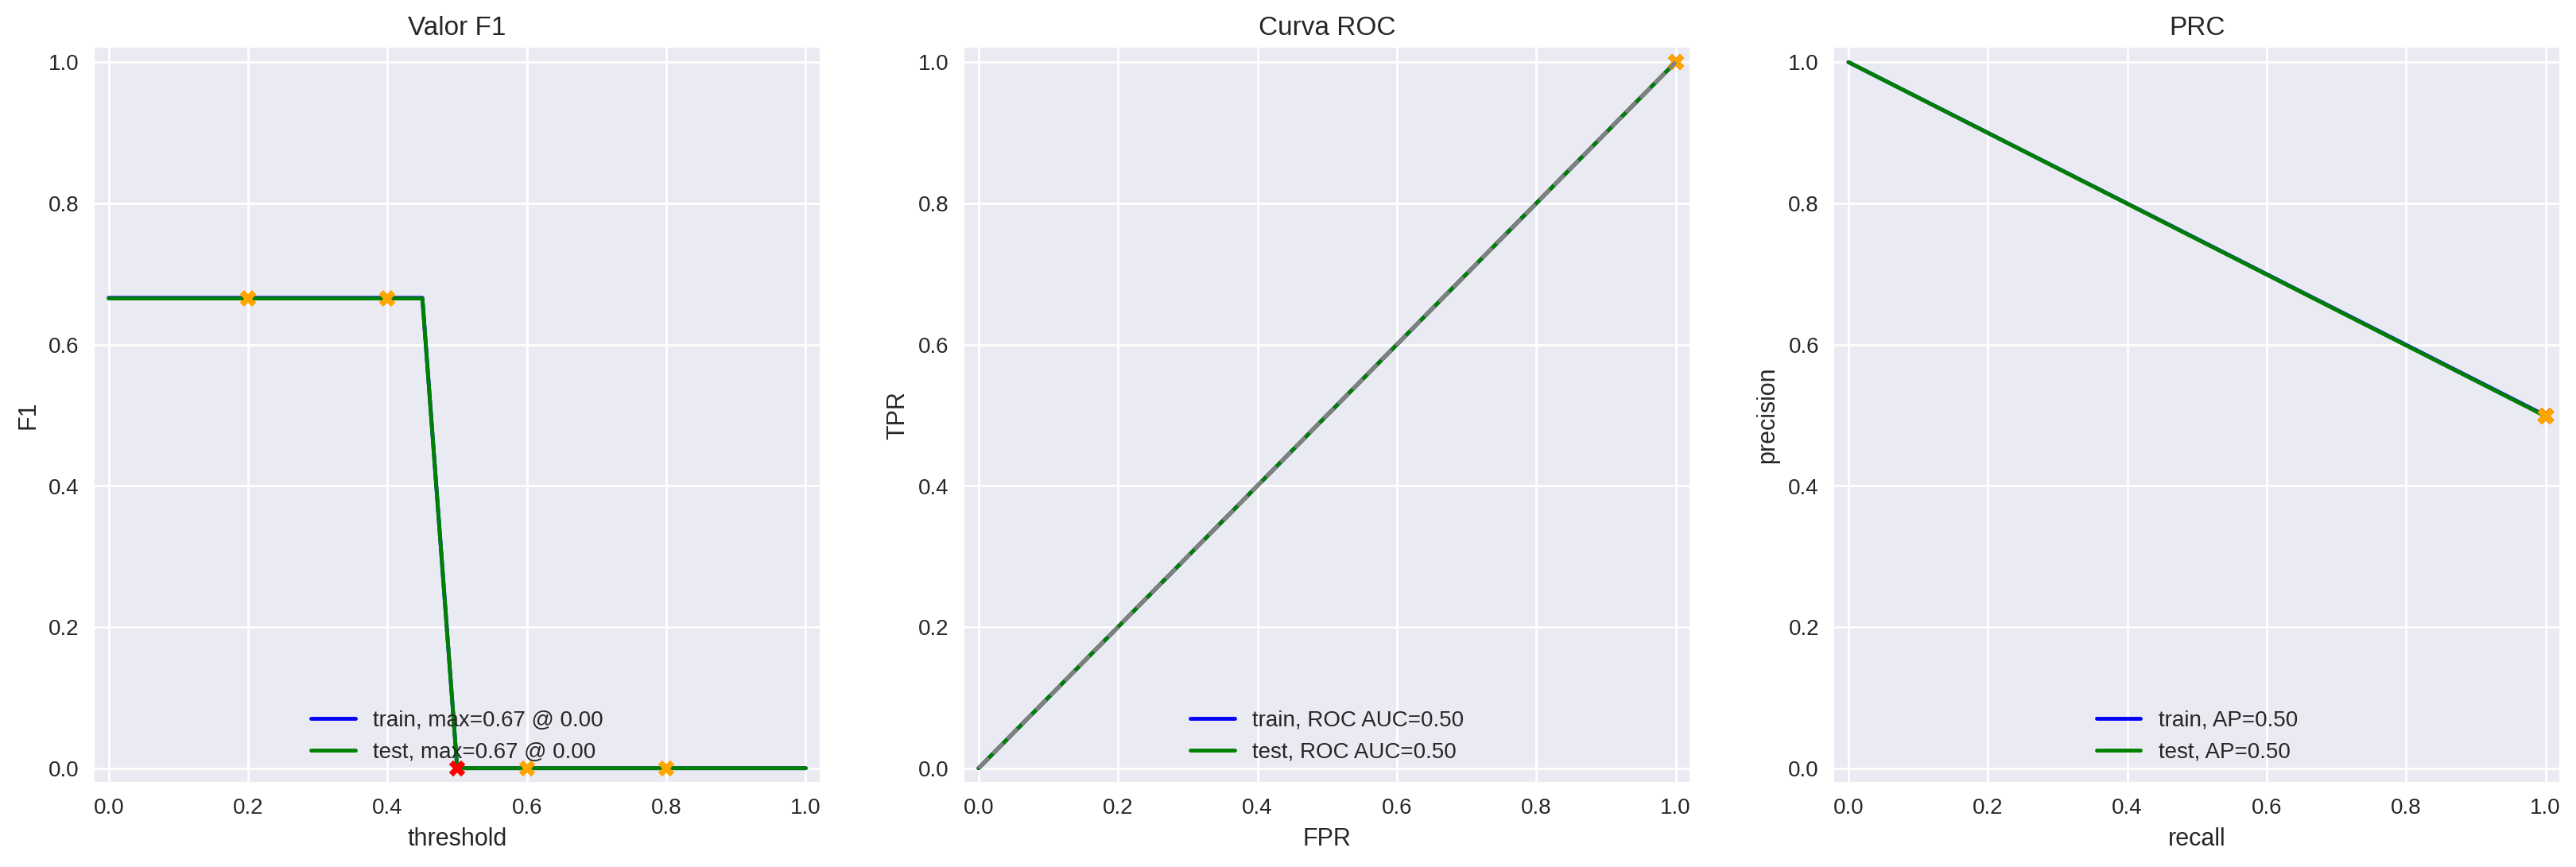

In [31]:
evaluate_model(dummy,df_reviews_train, train_target, df_reviews_test, test_target)

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [41]:
import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt_tab to /home/daniel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/daniel/nltk_data...


In [33]:
#Función para lematizar textos mediante las herramientas nltk
def lematizar (texts):
    lemmatizer = WordNetLemmatizer()
    
    return [" ".join(lemmatizer.lemmatize(word) for word in word_tokenize(text)) for text in texts]
    

In [42]:
#Lematización de las reseñas para los conjuntos train y test
df_reviews_train['review_norm_nltk'] = lematizar(df_reviews_train['review_norm'])
df_reviews_test['review_norm_nltk']= lematizar(df_reviews_test['review_norm'])

In [44]:
#Vectorización de las reseñas mediante la herramieta TF-IDF
#stop_words = set(stopwords.words('english'))
tf_idf_nltk = TfidfVectorizer(stop_words = 'english')
tf_idf_nltk.fit(df_reviews_train['review_norm_nltk'])
tf_idf_train_nltk = tf_idf_nltk.transform(df_reviews_train['review_norm_nltk'])
tf_idf_test_nltk = tf_idf_nltk.transform(df_reviews_test['review_norm_nltk'])

In [45]:
#Entrenamiento de la Regresión lineal en base a las reseñas vectorizadas
logistic = LogisticRegression()
logistic.fit(tf_idf_train_nltk, train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


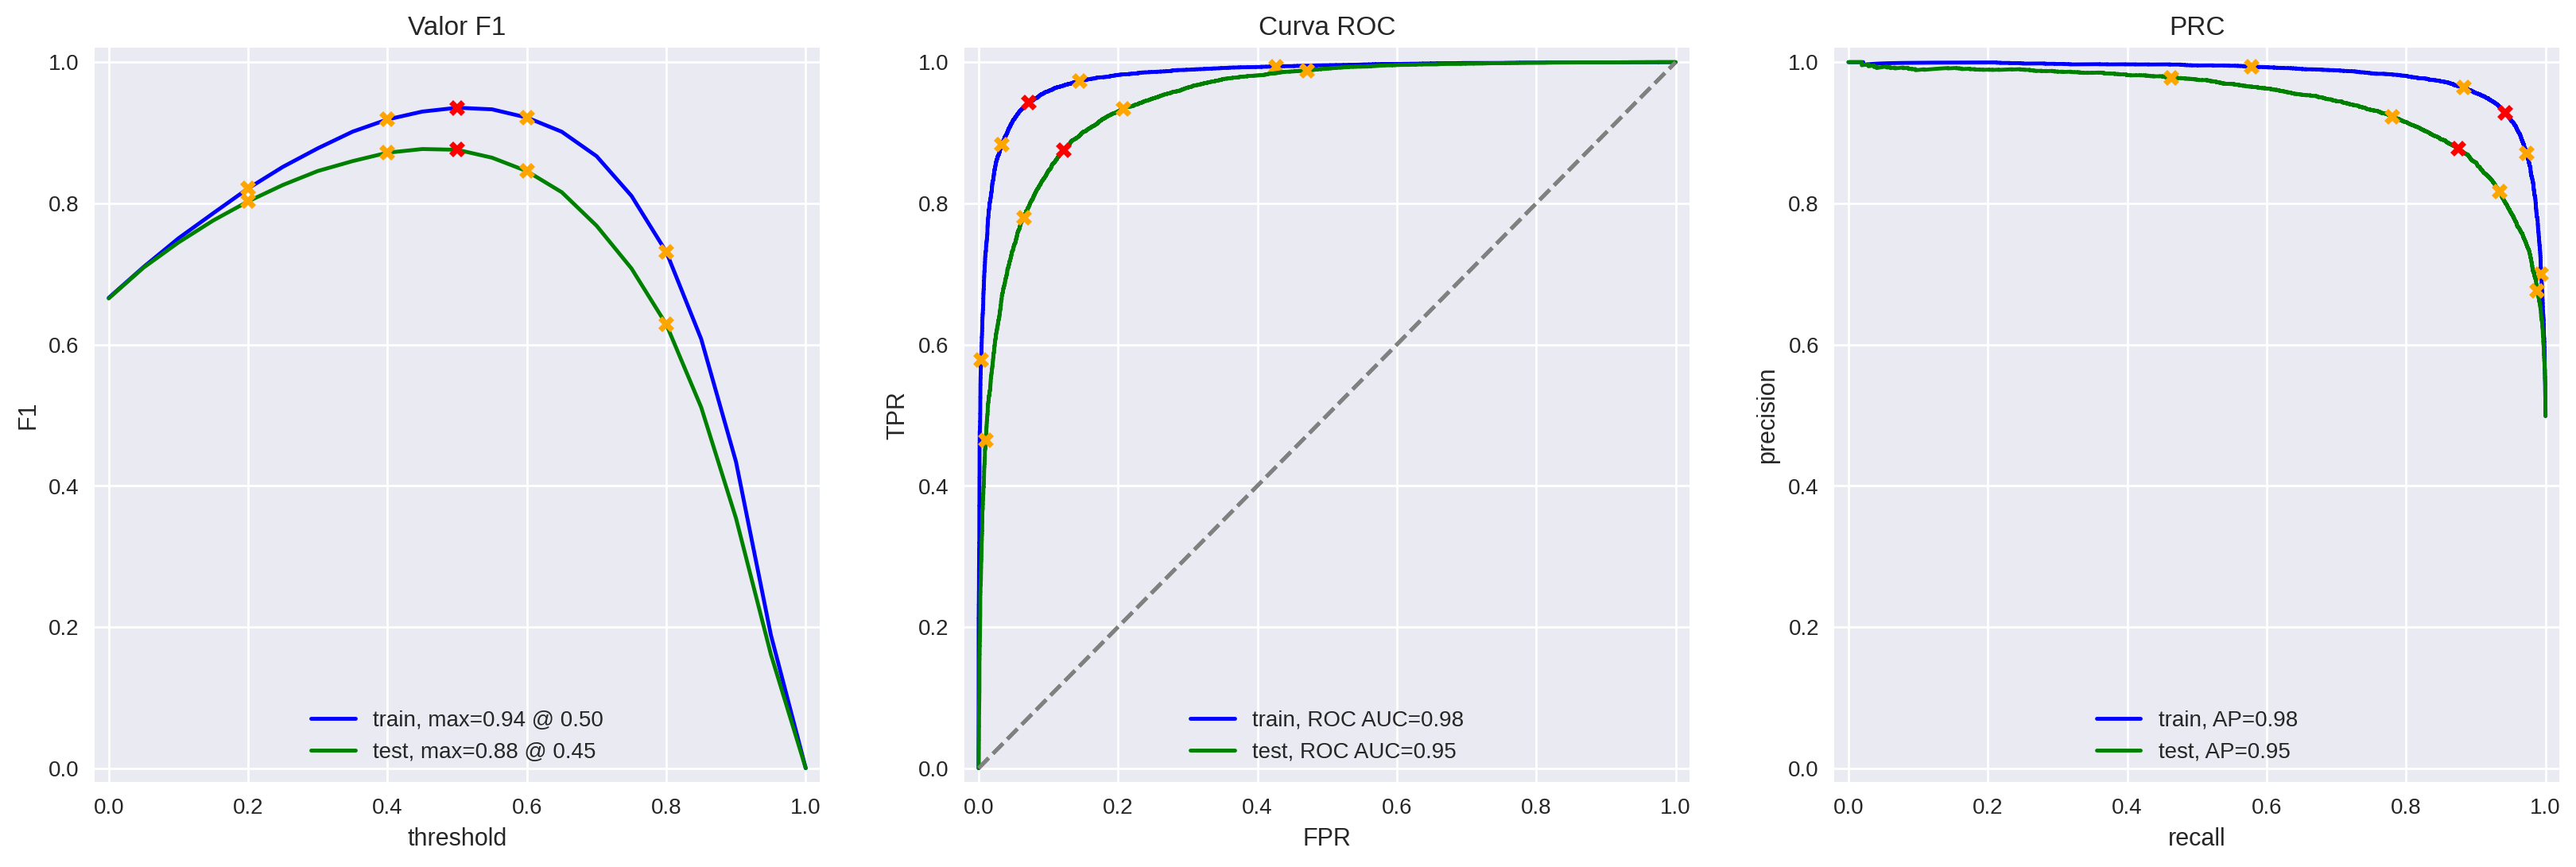

In [46]:
#Evaluación del modelo
evaluate_model(logistic, tf_idf_train_nltk, train_target, tf_idf_test_nltk, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [48]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [49]:
#Función para lematizar textos mediante las herramientas spacy
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [50]:
#Lematización de las reseñas para los conjuntos train y test
df_reviews_train['review_norm_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_norm_spacy']= df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [52]:
#Vectorización de las reseñas mediante la herramieta TF-IDF
#stop_words = set(stopwords.words('english'))
tf_idf_spacy = TfidfVectorizer(stop_words = 'english')
tf_idf_spacy.fit(df_reviews_train['review_norm_spacy'])
tf_idf_train_spacy = tf_idf_spacy.transform(df_reviews_train['review_norm_spacy'])
tf_idf_test_spacy = tf_idf_spacy.transform(df_reviews_test['review_norm_spacy'])

In [53]:
#Entrenamiento de la Regresión lineal en base a las reseñas vectorizadas
logistic2 = LogisticRegression()
logistic2.fit(tf_idf_train_spacy, train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


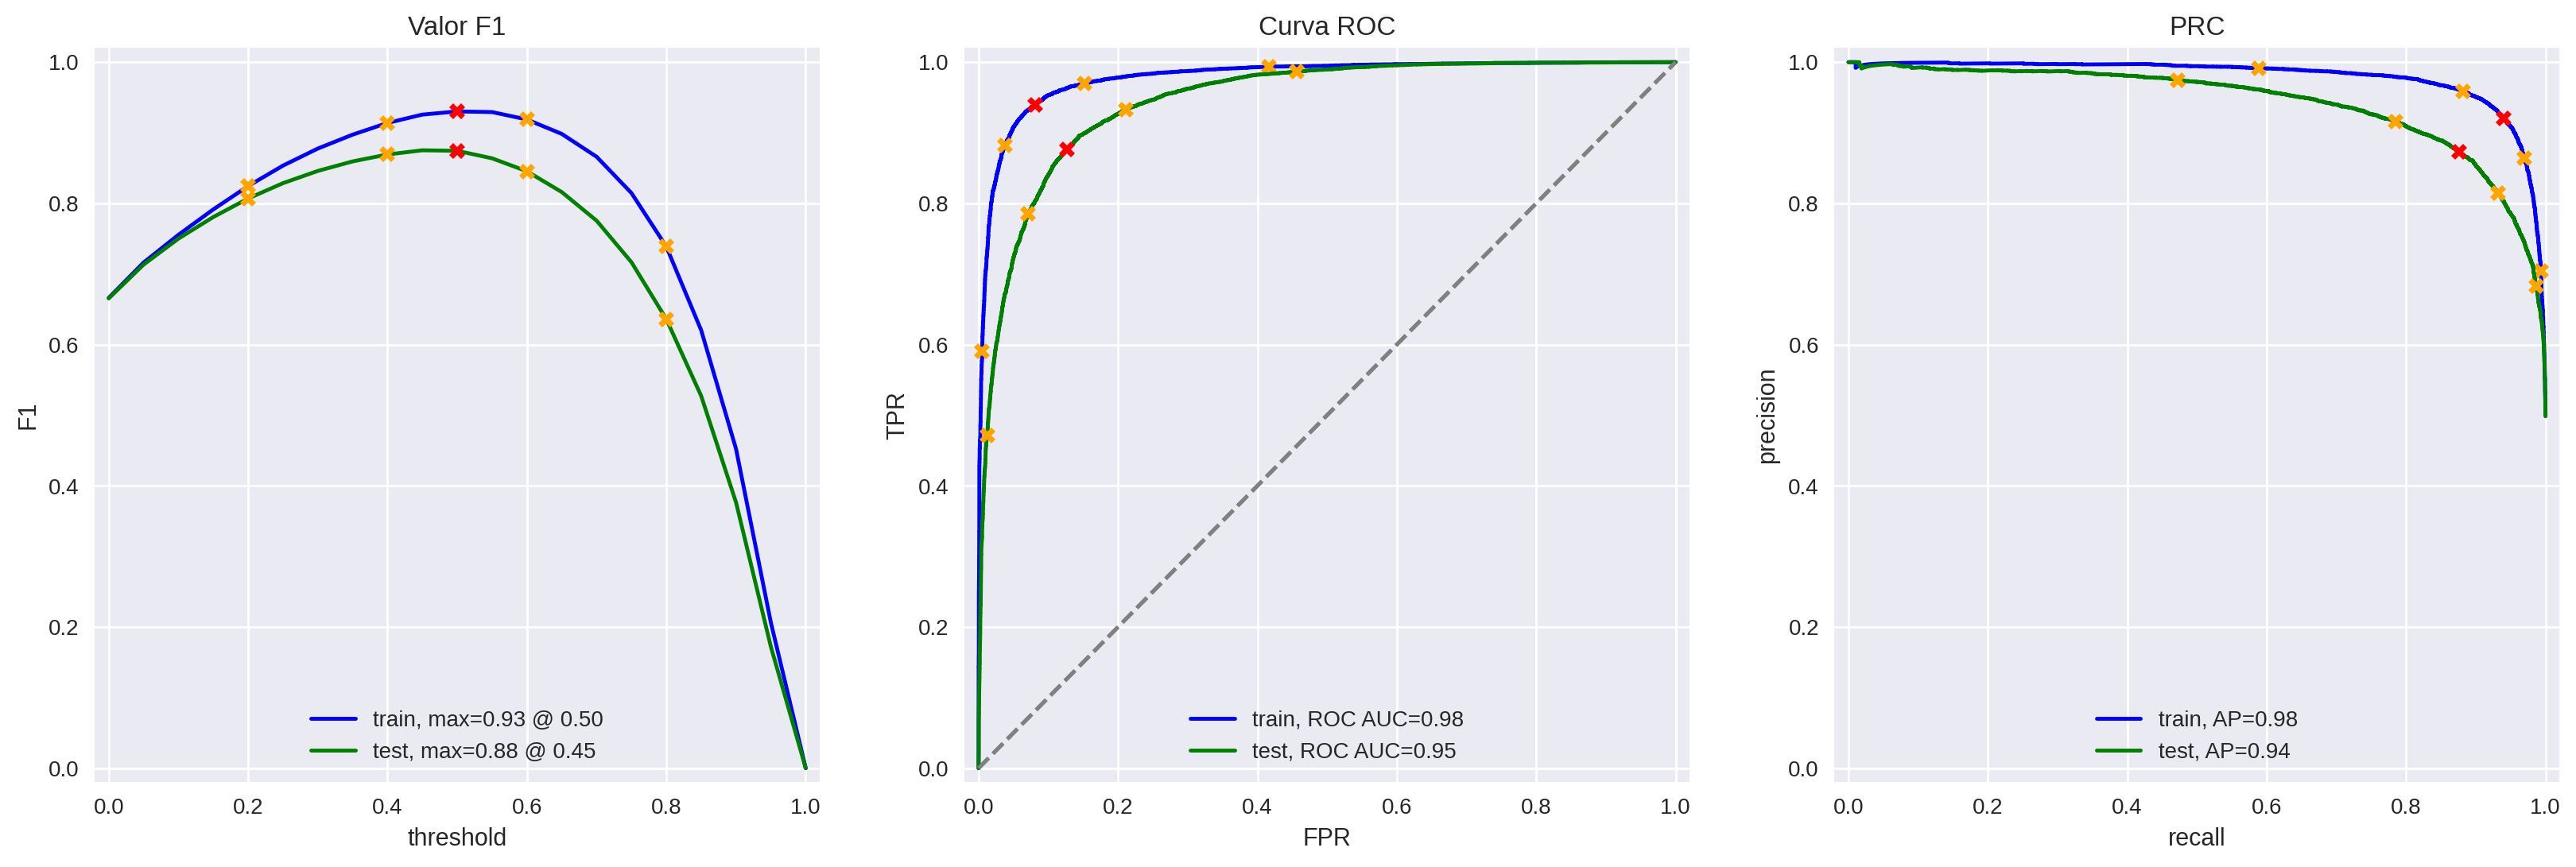

In [54]:
#Evaluación del modelo
evaluate_model(logistic2, tf_idf_train_spacy, train_target, tf_idf_test_spacy, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [56]:
from lightgbm import LGBMClassifier

In [57]:
#Entrenamiento del modelo LighGBM Classifier en base a las reseñas vectorizadas con TF-IDF
lgbm = LGBMClassifier(learning_rate=(0.1), n_estimators=100, random_state=1234,verbose = -1)
lgbm.fit(tf_idf_train_spacy, train_target)

/home/daniel/Documentos/CURSO TRIPLE TEN/Sprint 15/clases plataforma/vetext/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LGBMClassifier(random_state=1234, verbose=-1)

/home/daniel/Documentos/CURSO TRIPLE TEN/Sprint 15/clases plataforma/vetext/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/daniel/Documentos/CURSO TRIPLE TEN/Sprint 15/clases plataforma/vetext/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/daniel/Documentos/CURSO TRIPLE TEN/Sprint 15/clases plataforma/vetext/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/daniel/Documentos/CURSO TRIPLE TEN/Sprint 15/clases plataforma/vetext/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


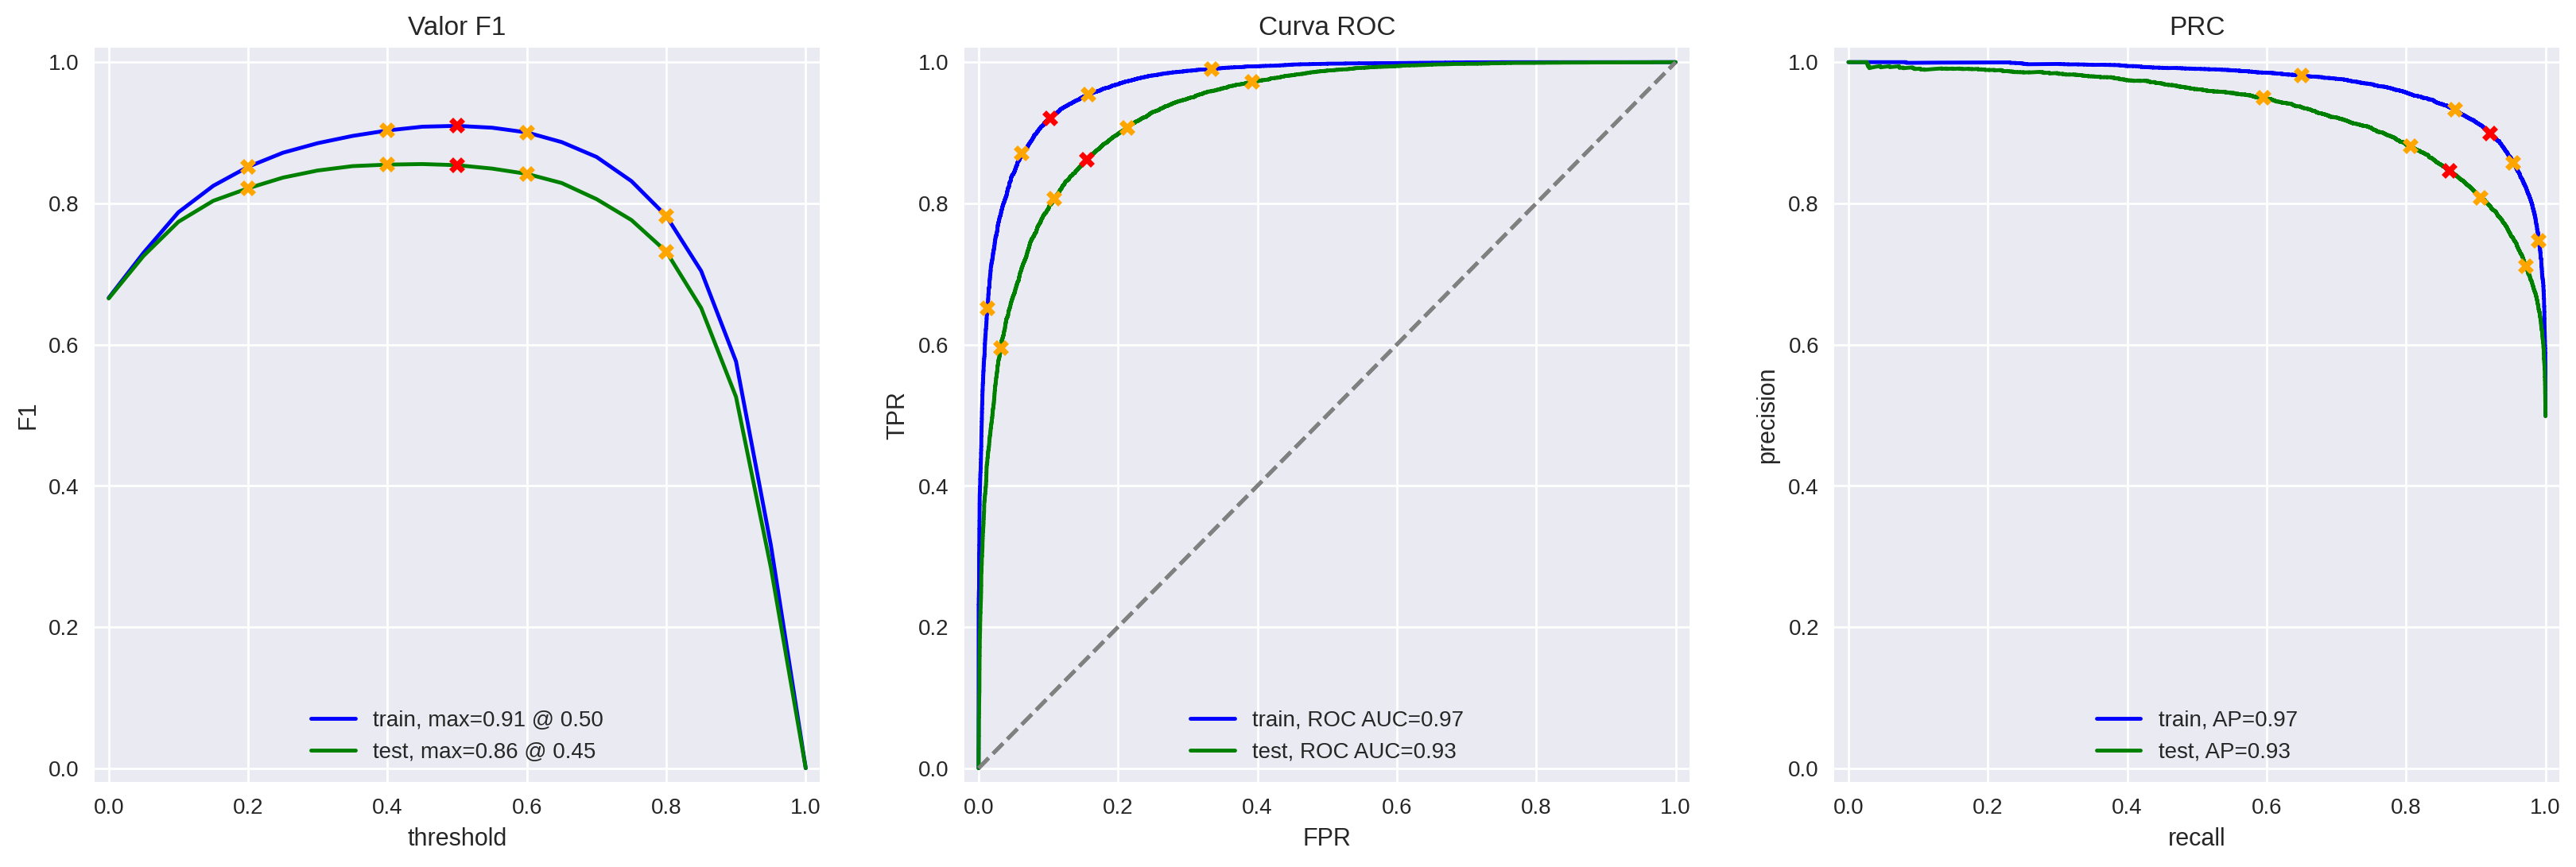

In [58]:
#Evaluación del modelo
evaluate_model(lgbm, tf_idf_train_spacy, train_target, tf_idf_test_spacy, test_target)

###  Modelo 9 - BERT

In [59]:
import torch
import transformers

In [60]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención 
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

## Mis reseñas

In [69]:
#Creación de un dataframe con nuevas reseñas a ser categorizadas
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])
 
'''No me gustó simplemente, no es mi tipo de película.',
'Bueno, estaba aburrido y me quedé dormido en medio de la película.',
'Estaba realmente fascinado con la película",    
"Incluso los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. ¡Qué robo de efectivo tan desalmado!',
'¡No esperaba que el reinicio fuera tan bueno! Los escritores realmente se preocuparon por el material original',
"La película tuvo sus ventajas y desventajas, pero creo que en general es una película decente. Me veo yendo a verlo otra vez.',
'Qué pésimo intento de comedia. No sale ni un solo chiste, todo el mundo actúa de forma molesta y ruidosa, ¡ni siquiera a los niños les gustará esto!',
"El lanzamiento en Netflix fue un movimiento valiente y realmente aprecio poder disfrutar episodio tras episodio de este nuevo e inteligente drama emocionante"'''

#Normalización de las reseñas
my_reviews['review_norm'] = my_reviews['review'].str.lower().apply(limpieza)
my_reviews['pos'] = pd.Series([0,0,1,0,1,1,0,1])
my_reviews

,review,review_norm,pos
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie,0
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...,0
2,I was really fascinated with the movie,i was really fascinated with the movie,1
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...,0
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...,1
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...,1
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...,0
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...,1


### Modelo 1

In [62]:
texts = my_reviews['review_norm']

#Presentación de las probabilidades generadas por el modelo 1 para el nuevo conjunto de textos
my_reviews_pred_prob = logistic.predict_proba(tf_idf_nltk.transform(lematizar(texts)))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.11:  i did not simply like it not my kind of movie
0.06:  well i was bored and felt asleep in the middle of the movie
0.51:  i was really fascinated with the movie
0.19:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.24:  i didn t expect the reboot to be so good writers really cared about the source material
0.48:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.90:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


In [63]:
#Cálculo de métricas para el modelo 1
model_1_acc = metrics.accuracy_score(my_reviews['pos'],logistic.predict(tf_idf_nltk.transform(texts)))
model_1_f1 = metrics.f1_score(my_reviews['pos'],logistic.predict(tf_idf_nltk.transform(texts)))

### Modelo 3

In [64]:
texts = my_reviews['review_norm']

#Presentación de las probabilidades generadas por el modelo 3 para el nuevo conjunto de textos
my_reviews_pred_prob = logistic2.predict_proba(tf_idf_spacy.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.09:  well i was bored and felt asleep in the middle of the movie
0.63:  i was really fascinated with the movie
0.20:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.20:  i didn t expect the reboot to be so good writers really cared about the source material
0.49:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


In [65]:
#Cálculo de métricas para el modelo 3
model_3_acc = metrics.accuracy_score(my_reviews['pos'],logistic2.predict(tf_idf_spacy.transform(texts.apply(lambda x: text_preprocessing_3(x)))))
model_3_f1 = metrics.f1_score(my_reviews['pos'],logistic2.predict(tf_idf_spacy.transform(texts.apply(lambda x: text_preprocessing_3(x)))))

### Modelo 4

In [66]:
texts = my_reviews['review_norm']

#Copia del vectorizador creado con la herramienta spacy
tfidf_vectorizer_4 = tf_idf_spacy
#Presentación de las probabilidades generadas por el modelo 4 para el nuevo conjunto de textos
my_reviews_pred_prob = lgbm.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.61:  i did not simply like it not my kind of movie
0.35:  well i was bored and felt asleep in the middle of the movie
0.62:  i was really fascinated with the movie
0.48:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.71:  i didn t expect the reboot to be so good writers really cared about the source material
0.60:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.31:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


/home/daniel/Documentos/CURSO TRIPLE TEN/Sprint 15/clases plataforma/vetext/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [67]:
#Cálculo de métricas para el modelo 3
model_4_acc = metrics.accuracy_score(my_reviews['pos'],lgbm.predict(tf_idf_spacy.transform(texts.apply(lambda x: text_preprocessing_3(x)))))
model_4_f1 = metrics.f1_score(my_reviews['pos'],lgbm.predict(tf_idf_spacy.transform(texts.apply(lambda x: text_preprocessing_3(x)))))

/home/daniel/Documentos/CURSO TRIPLE TEN/Sprint 15/clases plataforma/vetext/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


**Comparación Métricas**

In [68]:
#Creación de un DataFrame con las métricas de cada modelo
modelos_prueba = pd.DataFrame({'Accuracy': [model_1_acc,model_3_acc,model_4_acc],'F1':[model_1_f1,model_3_f1,model_4_f1]},
                      index=['Modelo 1','Modelo 3','Modelo 4'])
modelos_prueba

,Accuracy,F1
Modelo 1,0.750,0.666667
Modelo 3,0.750,0.666667
Modelo 4,0.875,0.888889


### Modelo 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusiones

La revisión previa de los datos no requirió mayor cambio, ya que para el procesamiento, solo se comprobó que no existieran datos faltantes o errores en las columnas de reviews y pos, que son las que se utilizan para el procesamiento del texto y entrenamiento de modelos.

El análisis exploratorio de datos nos ayudó a analizar lo siguiente:
- Los datos contenidos históricamente en el conjunto indican que hay una mayor cantidad de películas a medida que avanza el tiempo.
- La mayoría de películas tienen pocas reseñas (1-3 por película), salvo por un pico en que unas 400 películas acumulan 30 comentarios.
- La proporción de reseñas negativas y positivas está bastante balanceada tanto en el conjunto de entrenamiento como de prueba.
- Según los gráficos, muchas películas tienen solo 1 a 2 reseñas negativas, mientras que algunas acumulan muchas reseñas positivas y por ende está mas distribuida su curva.

En la comparación de modelos y las formas de lematizar con los datos descargados:
- Los métodos nltk y spacy utilizados para lematizar, dieron métricas casi idénticas al compararlos usando un modelo de regresión para predecir el conjunto de prueba.
- El vectorizador fue TF-IDF en todos los modelos entrenados, por tanto no hay distinción en este aspecto.
- Tanto la regresión Logística como el modelo de gradiente LGBM obtuvieron scores muy buenos y similares para el conjunto de entrenamiento (f1 entre 0.91 y 0.94) y prueba (f1 entre 0.86 y 0.88).
- Todos los modelos superaron por un margen amplio al modelo dummy.

En la comparación de modelos con los datos creados:
- Manualmente clasifiqué las reseñas entre positivas y negativas para comparar con la predicción del modelo.
- El mejor modelo para predecir el sentimiento en los comentarios fue el LightGBM.
- El peor modelo fue la regresión logística que utilizó la lematización de Spacy.
- Los valores de F1 en comparación con los del conjunto de prueba son bastante similares (cercanos a 0.88).
